In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

In [8]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [125, 240, -35, 25]}

In [9]:
domain = domains.domains['Water_Watch']

### import libraries for validation

In [10]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [11]:
verif_dset = 'ERA'
quantile = 'quartile'
varname = 'TPRATE'
period = 'monthly'
step = 1

In [12]:
# Parameters
step = 3
period = "seasonal"


In [13]:
opath_mme_probabilities = CWD.parents[1].joinpath(f"outputs/C3S_MME_{quantile}_probabilities")

In [14]:
lfiles = list(opath_mme_probabilities.glob("*"))

In [15]:
lfiles

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_quartile_probabilities/C3S_MME_monthly_quartile_probabilities.zarr'),
 PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_quartile_probabilities/C3S_MME_seasonal_quartile_probabilities.zarr')]

In [16]:
dset_mme = xr.open_zarr(opath_mme_probabilities.joinpath(f"C3S_MME_{period}_{quantile}_probabilities.zarr"))

In [17]:
dset_mme

,Array,Chunk
Bytes,2.02 GiB,1.76 MiB
Shape,"(8, 288, 4, 3, 81, 121)","(8, 288, 1, 1, 10, 10)"
Count,1405 Tasks,1404 Chunks
Type,float64,numpy.ndarray


### take the leadtime in the GCM

In [18]:
dset_mme = dset_mme.sel(step=step)

In [19]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 3
    time     datetime64[ns] 1993-01-01

In [20]:
dset_mme['time'] = dset_mme.indexes['time'] + pd.offsets.MonthBegin(step)

In [21]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 3
    time     datetime64[ns] 1993-04-01

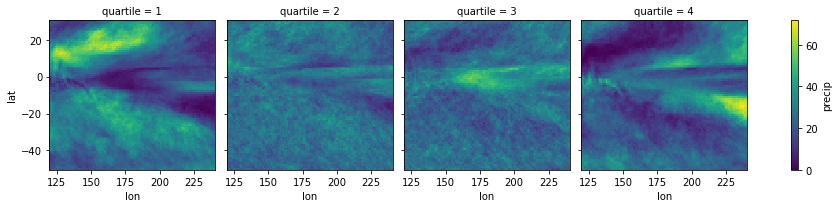

In [22]:
dset_mme.sel(GCM='MME').isel(time=0)['precip'].plot(x='lon', y='lat', col=quantile)

### most likely quartile 

In [23]:
dset_mme = dset_mme.idxmax(dim=quantile)

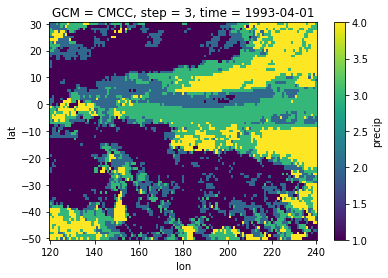

In [24]:
dset_mme['precip'][0,0,:,:].plot()

### Now reads in the verification dataset 

In [25]:
opath_verif_categories = CWD.parents[1].joinpath(f"outputs/{verif_dset}_{quantile}_categories")

In [26]:
verif_quantile_categories = xr.open_zarr(opath_verif_categories.joinpath(f"{verif_dset}_{quantile}_{period}_categories.zarr"))

### merge the datasets 

In [27]:
dset_mme, verif_quantile_categories = xr.align(dset_mme, verif_quantile_categories)

In [28]:
dset_merge = dset_mme.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories.rename_vars({'precip':'verif'}))

In [29]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, time: 285, GCM: 8, lon: 121)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * time     (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 3
    month    (time) int64 dask.array<chunksize=(285,), meta=np.ndarray>
Data variables:
    gcm      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 285, 5, 10), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

### rechunk 

In [30]:
dset_merge = dset_merge.chunk({'time':-1, 'lat':10, 'lon':10},)

In [31]:
dset_merge.nbytes / 1e9

0.151464044

In [32]:
with ProgressBar(): 
    dset_merge = dset_merge.compute()

[                                        ] | 0% Completed |  0.0s

[                                        ] | 0% Completed |  0.2s

[                                        ] | 0% Completed |  0.4s

[                                        ] | 0% Completed |  0.5s

[                                        ] | 0% Completed |  0.7s

[                                        ] | 0% Completed |  0.8s

[                                        ] | 0% Completed |  1.0s

[                                        ] | 0% Completed |  1.3s

[                                        ] | 0% Completed |  1.5s

[                                        ] | 0% Completed |  1.6s

[                                        ] | 1% Completed |  1.7s

[                                        ] | 1% Completed |  1.8s

[                                        ] | 2% Completed |  1.9s

[#                                       ] | 2% Completed |  2.0s

[#                                       ] | 3% Completed |  2.1s

[#                                       ] | 3% Completed |  2.2s

[#                                       ] | 4% Completed |  2.3s

[#                                       ] | 4% Completed |  2.4s

[#                                       ] | 4% Completed |  2.5s

[##                                      ] | 5% Completed |  2.6s

[##                                      ] | 5% Completed |  2.7s

[##                                      ] | 6% Completed |  2.8s

[##                                      ] | 6% Completed |  2.9s

[##                                      ] | 6% Completed |  3.0s

[##                                      ] | 7% Completed |  3.1s

[##                                      ] | 7% Completed |  3.2s

[##                                      ] | 7% Completed |  3.3s

[##                                      ] | 7% Completed |  3.4s

[##                                      ] | 7% Completed |  3.5s

[##                                      ] | 7% Completed |  3.6s

[###                                     ] | 7% Completed |  3.7s

[###                                     ] | 7% Completed |  3.8s

[###                                     ] | 7% Completed |  3.9s

[###                                     ] | 7% Completed |  4.0s

[###                                     ] | 8% Completed |  4.1s

[###                                     ] | 9% Completed |  4.2s

[####                                    ] | 10% Completed |  4.3s

[####                                    ] | 11% Completed |  4.4s

[####                                    ] | 12% Completed |  4.5s

[#####                                   ] | 12% Completed |  4.6s

[#####                                   ] | 13% Completed |  4.7s

[#####                                   ] | 13% Completed |  4.8s

[#####                                   ] | 14% Completed |  4.9s

[#####                                   ] | 14% Completed |  5.1s

[######                                  ] | 15% Completed |  5.2s

[######                                  ] | 16% Completed |  5.3s

[######                                  ] | 16% Completed |  5.4s

[######                                  ] | 16% Completed |  5.5s

[######                                  ] | 16% Completed |  5.6s

[######                                  ] | 17% Completed |  5.7s

[######                                  ] | 17% Completed |  5.8s

[#######                                 ] | 17% Completed |  5.9s

[#######                                 ] | 17% Completed |  6.0s

[#######                                 ] | 18% Completed |  6.1s

[#######                                 ] | 18% Completed |  6.2s

[#######                                 ] | 18% Completed |  6.3s

[#######                                 ] | 18% Completed |  6.4s

[#######                                 ] | 18% Completed |  6.5s

[#######                                 ] | 19% Completed |  6.6s

[#######                                 ] | 19% Completed |  6.7s

[#######                                 ] | 19% Completed |  6.8s

[#######                                 ] | 19% Completed |  6.9s

[#######                                 ] | 19% Completed |  7.0s

[#######                                 ] | 19% Completed |  7.1s

[#######                                 ] | 19% Completed |  7.2s

[#######                                 ] | 19% Completed |  7.3s

[########                                ] | 20% Completed |  7.4s

[########                                ] | 20% Completed |  7.5s

[########                                ] | 20% Completed |  7.6s

[########                                ] | 20% Completed |  7.7s

[########                                ] | 20% Completed |  7.9s

[########                                ] | 20% Completed |  8.0s

[########                                ] | 20% Completed |  8.1s

[########                                ] | 20% Completed |  8.2s

[########                                ] | 21% Completed |  8.3s

[########                                ] | 21% Completed |  8.4s

[########                                ] | 21% Completed |  8.5s

[########                                ] | 21% Completed |  8.6s

[########                                ] | 21% Completed |  8.7s

[########                                ] | 21% Completed |  8.8s

[########                                ] | 21% Completed |  8.9s

[########                                ] | 22% Completed |  9.0s

[########                                ] | 22% Completed |  9.1s

[#########                               ] | 22% Completed |  9.2s

[#########                               ] | 23% Completed |  9.3s

[#########                               ] | 23% Completed |  9.4s

[#########                               ] | 23% Completed |  9.5s

[#########                               ] | 24% Completed |  9.6s

[#########                               ] | 24% Completed |  9.7s

[#########                               ] | 24% Completed |  9.8s

[#########                               ] | 24% Completed |  9.9s

[#########                               ] | 24% Completed | 10.0s

[#########                               ] | 24% Completed | 10.1s

[##########                              ] | 25% Completed | 10.2s

[##########                              ] | 25% Completed | 10.3s

[##########                              ] | 25% Completed | 10.4s

[##########                              ] | 25% Completed | 10.5s

[##########                              ] | 26% Completed | 10.6s

[##########                              ] | 26% Completed | 10.7s

[##########                              ] | 26% Completed | 10.8s

[##########                              ] | 26% Completed | 10.9s

[##########                              ] | 26% Completed | 11.0s

[##########                              ] | 27% Completed | 11.1s

[##########                              ] | 27% Completed | 11.2s

[###########                             ] | 28% Completed | 11.3s

[###########                             ] | 28% Completed | 11.4s

[###########                             ] | 28% Completed | 11.5s

[###########                             ] | 29% Completed | 11.7s

[###########                             ] | 29% Completed | 11.8s

[###########                             ] | 29% Completed | 11.9s

[###########                             ] | 29% Completed | 12.0s

[############                            ] | 30% Completed | 12.1s

[############                            ] | 30% Completed | 12.2s

[############                            ] | 30% Completed | 12.3s

[############                            ] | 31% Completed | 12.4s

[############                            ] | 31% Completed | 12.5s

[############                            ] | 31% Completed | 12.6s

[############                            ] | 31% Completed | 12.7s

[############                            ] | 32% Completed | 12.8s

[############                            ] | 32% Completed | 12.9s

[############                            ] | 32% Completed | 13.0s

[#############                           ] | 32% Completed | 13.1s

[#############                           ] | 32% Completed | 13.2s

[#############                           ] | 32% Completed | 13.3s

[#############                           ] | 32% Completed | 13.4s

[#############                           ] | 32% Completed | 13.5s

[#############                           ] | 33% Completed | 13.6s

[#############                           ] | 33% Completed | 13.7s

[#############                           ] | 33% Completed | 13.8s

[#############                           ] | 33% Completed | 13.9s

[#############                           ] | 33% Completed | 14.0s

[#############                           ] | 33% Completed | 14.1s

[#############                           ] | 34% Completed | 14.2s

[#############                           ] | 34% Completed | 14.3s

[##############                          ] | 35% Completed | 14.4s

[##############                          ] | 35% Completed | 14.5s

[##############                          ] | 35% Completed | 14.6s

[##############                          ] | 35% Completed | 14.7s

[##############                          ] | 36% Completed | 14.8s

[##############                          ] | 36% Completed | 15.0s

[##############                          ] | 36% Completed | 15.1s

[##############                          ] | 36% Completed | 15.2s

[##############                          ] | 37% Completed | 15.3s

[##############                          ] | 37% Completed | 15.4s

[###############                         ] | 37% Completed | 15.5s

[###############                         ] | 37% Completed | 15.6s

[###############                         ] | 38% Completed | 15.7s

[###############                         ] | 38% Completed | 15.8s

[###############                         ] | 39% Completed | 15.9s

[###############                         ] | 39% Completed | 16.0s

[################                        ] | 40% Completed | 16.1s

[################                        ] | 40% Completed | 16.2s

[################                        ] | 40% Completed | 16.3s

[################                        ] | 40% Completed | 16.4s

[################                        ] | 40% Completed | 16.5s

[################                        ] | 41% Completed | 16.6s

[################                        ] | 41% Completed | 16.7s

[################                        ] | 41% Completed | 16.8s

[################                        ] | 41% Completed | 16.9s

[################                        ] | 41% Completed | 17.0s

[################                        ] | 41% Completed | 17.1s

[################                        ] | 41% Completed | 17.2s

[################                        ] | 42% Completed | 17.3s

[################                        ] | 42% Completed | 17.4s

[#################                       ] | 42% Completed | 17.5s

[#################                       ] | 42% Completed | 17.6s

[#################                       ] | 43% Completed | 17.7s

[#################                       ] | 43% Completed | 17.8s

[#################                       ] | 43% Completed | 17.9s

[#################                       ] | 43% Completed | 18.0s

[#################                       ] | 43% Completed | 18.1s

[#################                       ] | 44% Completed | 18.2s

[#################                       ] | 44% Completed | 18.3s

[#################                       ] | 44% Completed | 18.4s

[#################                       ] | 44% Completed | 18.5s

[#################                       ] | 44% Completed | 18.7s

[##################                      ] | 45% Completed | 18.8s

[##################                      ] | 45% Completed | 18.9s

[##################                      ] | 45% Completed | 19.0s

[##################                      ] | 46% Completed | 19.1s

[##################                      ] | 46% Completed | 19.2s

[##################                      ] | 46% Completed | 19.3s

[##################                      ] | 47% Completed | 19.4s

[##################                      ] | 47% Completed | 19.5s

[###################                     ] | 47% Completed | 19.6s

[###################                     ] | 48% Completed | 19.7s

[###################                     ] | 48% Completed | 19.8s

[###################                     ] | 48% Completed | 19.9s

[###################                     ] | 48% Completed | 20.0s

[###################                     ] | 49% Completed | 20.1s

[###################                     ] | 49% Completed | 20.2s

[####################                    ] | 50% Completed | 20.3s

[####################                    ] | 50% Completed | 20.4s

[####################                    ] | 50% Completed | 20.5s

[####################                    ] | 51% Completed | 20.6s

[####################                    ] | 51% Completed | 20.7s

[####################                    ] | 52% Completed | 20.8s

[#####################                   ] | 52% Completed | 20.9s

[#####################                   ] | 52% Completed | 21.0s

[#####################                   ] | 53% Completed | 21.1s

[#####################                   ] | 53% Completed | 21.2s

[#####################                   ] | 54% Completed | 21.3s

[#####################                   ] | 54% Completed | 21.4s

[#####################                   ] | 54% Completed | 21.5s

[######################                  ] | 55% Completed | 21.6s

[######################                  ] | 55% Completed | 21.7s

[######################                  ] | 55% Completed | 21.8s

[######################                  ] | 55% Completed | 21.9s

[######################                  ] | 55% Completed | 22.0s

[######################                  ] | 55% Completed | 22.1s

[######################                  ] | 56% Completed | 22.2s

[######################                  ] | 56% Completed | 22.3s

[######################                  ] | 57% Completed | 22.4s

[#######################                 ] | 57% Completed | 22.5s

[#######################                 ] | 58% Completed | 22.6s

[#######################                 ] | 58% Completed | 22.7s

[#######################                 ] | 59% Completed | 22.8s

[#######################                 ] | 59% Completed | 22.9s

[########################                ] | 60% Completed | 23.0s

[########################                ] | 60% Completed | 23.1s

[########################                ] | 61% Completed | 23.2s

[########################                ] | 61% Completed | 23.3s

[########################                ] | 61% Completed | 23.4s

[########################                ] | 61% Completed | 23.5s

[########################                ] | 62% Completed | 23.7s

[#########################               ] | 62% Completed | 23.8s

[#########################               ] | 62% Completed | 23.9s

[#########################               ] | 62% Completed | 24.0s

[#########################               ] | 62% Completed | 24.1s

[#########################               ] | 63% Completed | 24.2s

[#########################               ] | 63% Completed | 24.3s

[#########################               ] | 64% Completed | 24.4s

[#########################               ] | 64% Completed | 24.5s

[#########################               ] | 64% Completed | 24.6s

[#########################               ] | 64% Completed | 24.7s

[#########################               ] | 64% Completed | 24.8s

[##########################              ] | 65% Completed | 24.9s

[##########################              ] | 65% Completed | 25.0s

[##########################              ] | 65% Completed | 25.1s

[##########################              ] | 65% Completed | 25.2s

[##########################              ] | 66% Completed | 25.3s

[##########################              ] | 66% Completed | 25.4s

[##########################              ] | 66% Completed | 25.5s

[##########################              ] | 66% Completed | 25.6s

[##########################              ] | 66% Completed | 25.7s

[##########################              ] | 66% Completed | 25.8s

[##########################              ] | 67% Completed | 25.9s

[##########################              ] | 67% Completed | 26.0s

[###########################             ] | 67% Completed | 26.1s

[###########################             ] | 67% Completed | 26.2s

[###########################             ] | 68% Completed | 26.3s

[###########################             ] | 68% Completed | 26.4s

[###########################             ] | 68% Completed | 26.5s

[###########################             ] | 68% Completed | 26.6s

[###########################             ] | 68% Completed | 26.7s

[###########################             ] | 69% Completed | 26.9s

[###########################             ] | 69% Completed | 27.0s

[###########################             ] | 69% Completed | 27.1s

[###########################             ] | 69% Completed | 27.2s

[###########################             ] | 69% Completed | 27.3s

[###########################             ] | 69% Completed | 27.4s

[############################            ] | 70% Completed | 27.5s

[############################            ] | 70% Completed | 27.6s

[############################            ] | 70% Completed | 27.7s

[############################            ] | 70% Completed | 27.8s

[############################            ] | 70% Completed | 27.9s

[############################            ] | 70% Completed | 28.0s

[############################            ] | 71% Completed | 28.1s

[############################            ] | 71% Completed | 28.2s

[############################            ] | 71% Completed | 28.3s

[############################            ] | 71% Completed | 28.4s

[############################            ] | 71% Completed | 28.5s

[############################            ] | 71% Completed | 28.6s

[############################            ] | 71% Completed | 28.7s

[############################            ] | 72% Completed | 28.8s

In [ ]:
dset_merge

In [ ]:
import xarray as xr 
from functools import partial
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix,\
precision_score

In [ ]:
def tp(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    intersection = ((x == class_value) * (y == class_value)).sum()
    # same as the and statement
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return intersection 

def fp(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    fps = ((x == class_value) * (~(y == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return fps

def fn(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    fns = ((y == class_value) * (~(x == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return fns

def tn(x, y, class_value): 
    tns = ((~(y == class_value)) * (~(x == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return tns

def iou(x, y, class_value):
    intersection = ((x == class_value) * (y == class_value)).sum()
    # multiplication ensures that this is only where both values equal the class set
    union_set = (x == class_value) + (y == class_value)
    # union will combine the two (e.g. when the predicted value is 0 and observed is 1)
    union_set = np.clip(union_set, a_min =0, a_max =1).sum()
    # clipping the set, as we only want a bolean union
    return intersection /union_set

def confusion_matrix_parallel(x, y):
    x = x-1
    y = y-1
    # converting the ones to zeros
    # Note see documentation if you'd like to normalize the data
    return confusion_matrix(x, y)
       
    

In [ ]:
def false_negatives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    fnegatives = xr.apply_ufunc(partial(fn, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return fnegatives

def false_positives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    fpositives = xr.apply_ufunc(partial(fp, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return fpositives

def true_positives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    tpositives = xr.apply_ufunc(partial(tp, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return tpositives

def true_negatives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    tnegatives = xr.apply_ufunc(partial(tn, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return tnegatives

In [ ]:
dset = dset_merge.sel(GCM='ECMWF')

In [ ]:
fnegatives = false_negatives(dset)

In [ ]:
fpositives = false_positives(dset)

In [ ]:
tpositives = true_positives(dset)

In [ ]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [ ]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

In [ ]:
precision.plot.contourf(levels=np.arange(0.2, 0.9,  0.1))

In [ ]:
dset = dset_merge.sel(GCM='MME')

In [ ]:
class_value = 1

In [ ]:
class_dict = {}
class_dict[1] = ['lower', '< 1st quartile']
class_dict[2] = ['mid-lower', 'between 1st quartile and median']
class_dict[3] = ['mid-upper', 'between median and 3rd quartile']
class_dict[4] = ['upper', '> 3rd quartile']

In [ ]:
fnegatives = false_negatives(dset, class_value=class_value)

In [ ]:
fpositives = false_positives(dset, class_value=class_value)

In [ ]:
tpositives = true_positives(dset, class_value=class_value)

In [ ]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [ ]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

In [ ]:
cbar_kwargs = dict(shrink=0.8, orientation='vertical', drawedges=True, pad=0.01)

In [ ]:
F1_Score = 2*(recall * precision) / (recall + precision)

In [ ]:
import palettable

In [ ]:
cmap = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

In [ ]:
cmap

In [ ]:
if period == 'seasonal': 
    period_label = 'season'
    lead = step - 2 
elif period == 'monthly': 
    period_label = 'month'
    lead = step

In [ ]:
# f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

# axes = axes.flatten()

# ax = axes[0]

# precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) precision, 1 season ahead")

# ax = axes[1]

# recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) recall, 1 season ahead")

# ax = axes[2]

# F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

# ax.coastlines(resolution='10m')

# ax.set_extent(domain, crs=ccrs.PlateCarree())

# ax.set_title(f"C3S MME, {category_name} category ({category_description}) F1 score, 1 season ahead")

# f.savefig(f'./{category_name}_precision_recall_F1score.png', dpi=200, bbox_inches='tight', facecolor='w')

In [ ]:
f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

axes = axes.flatten()

ax = axes[0]

precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) precision, {lead} {period_label} ahead")

ax = axes[1]

recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) recall,{lead} {period_label} ahead")

ax = axes[2]

F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {class_dict[class_value][0]} category ({class_dict[class_value][1]}) F1 score, {lead} {period_label} ahead")

# f.savefig(f'./{quantile}_{class_dict[class_value][0]}_precision_recall_F1score_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')

### ACCURACY

In [ ]:
acc = dset['gcm'] == dset['verif']

In [ ]:
acc = acc.sum('time') / len(acc.time)

In [ ]:
cbar_kwargs.update(shrink=0.5)

In [ ]:
cbar_kwargs

In [ ]:
f, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

acc.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, Accuracy [0 - 1], {lead} {period_label} ahead")

f.savefig(f'./{quantile}_{class_dict[class_value][0]}_accuracy_{lead}_{period_label}_ahead.png', dpi=200, bbox_inches='tight', facecolor='w')